In [1]:
%matplotlib inline
import pylab as pl

In [2]:
from astropy import units as u

In [3]:
from astropy.table import Table

In [4]:
import imf

In [5]:
import glob

# Load Robitaille 2017 -> Richardson 2023 Model Grid

### Theo's classification downselection

 * MS: 0 (below) / 1 (on/above) / -1 (too cold)
 * Stage: 0 (0) / 1 (I) / 2 (II) / 3 (III) / -1 (none)
 * Class: 0 (0) / 1 (I) / 2 (Flat) / 3 (II) / 4 (III) / -1 (none)

In [6]:
version = 'r+23_models-1.1'

In [7]:
pars = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/{version}/s---s-i/parameters.fits')

In [8]:
path=f'/blue/adamginsburg/richardson.t/research/flux/{version}/s---s-i/convolved/JWST/'

In [9]:
geoms = [x.split("/")[-2] for x in glob.glob(f'/blue/adamginsburg/richardson.t/research/flux/{version}/*/')
         if x.split("/")[-2].startswith('s')]

In [10]:
augpars_dict = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/{version}/{geom}/parameters.fits')
                for geom in geoms}
for key in augpars_dict:
    augpars_dict[key].add_index("MODEL_NAME")

In [11]:
classification_dict = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/real_models/{geom}.fits')
                       for geom in geoms}
for key in classification_dict:
    classification_dict[key].add_index("Model Name")

In [12]:
classification_dict['spubhmi'][:5]

<Table length=5>
 Model Name Above MS Stage Class
  bytes20    int64   int64 int64
----------- -------- ----- -----
0001EHII_01        1     1     1
0001EHII_02        1     1     1
0001EHII_03        1     1     1
0001EHII_04        1     1     1
0001EHII_05        1     1     1

In [13]:
import numpy as np
import regions
import warnings
import glob
from astropy.io import fits
from astropy import stats
import pylab as pl
from astropy import units as u
from grid_strategy import strategies
from astropy.table import Table
from astropy import wcs
from astropy.wcs import WCS
from astropy.visualization import simple_norm
import itertools
import dust_extinction
from dust_extinction.averages import RRP89_MWGC, CT06_MWGC, F11_MWGC
from dust_extinction.parameter_averages import CCM89
from grid_strategy import strategies

sqgrid = strategies.SquareStrategy()
rectgrid = strategies.RectangularStrategy()


In [14]:
filters = [x for x in glob.glob(f'{path}/*fits') if 'NIRISS' not in x and not ('NIRCam' in x and 'W.fits' in x)]

In [15]:
filters = [x for x in glob.glob(f'{path}/*fits') if 'NIRISS' not in x and not ('NIRCam' in x and 'W.fits' in x)]
mfilters = [x for x in glob.glob(f'{path}/MIRI*fits') if 'W.fits' in x]
nfilters = [x for x in glob.glob(f'{path}/NIR*fits')]
colors = list(itertools.combinations(mfilters, 2))
combos = list(itertools.combinations(colors, 2))
gridspec = sqgrid.get_grid(len(combos))
print(len(combos), len(colors))

630 36


<Figure size 432x288 with 0 Axes>

## Population Synthesis step

In [16]:
mean_mass = (imf.kroupa.m_integrate(0.03, 120)[0] / imf.kroupa.integrate(0.03, 120)[0])*u.M_sun
mean_mass

<Quantity 0.43392936 solMass>

In [17]:
massfrac_above_4msun = imf.kroupa.m_integrate(4, 120)[0] / imf.kroupa.m_integrate(0.03, 120)[0]
massfrac_above_4msun

0.29639934520306555

In [18]:
meanmass_above_4msun = (imf.kroupa.m_integrate(4, 120)[0] / imf.kroupa.integrate(4, 120)[0])*u.M_sun
meanmass_above_4msun

<Quantity 11.22008088 solMass>

In [19]:
# CMZ total sfr
sfr = 0.1*u.M_sun / u.yr
t_stage0 = 0.1*u.Myr
t_stage1 = 0.5*u.Myr
t_stage2 = 5.0*u.Myr
M_stage0 = t_stage0 * sfr
M_stage1 = t_stage1 * sfr
M_stage2 = t_stage2 * sfr

In [20]:
nysos_stage0 = (M_stage0 * massfrac_above_4msun / meanmass_above_4msun).decompose()
nysos_stage1 = (M_stage1 * massfrac_above_4msun / meanmass_above_4msun).decompose()
nysos_stage2 = (M_stage2 * massfrac_above_4msun / meanmass_above_4msun).decompose()

In [21]:
nysos_stage0, nysos_stage1, nysos_stage2

(<Quantity 264.16863512>, <Quantity 1320.84317559>, <Quantity 13208.43175592>)

In [22]:
massfrac_0p5to4 = imf.kroupa.m_integrate(0.5, 4)[0] / imf.kroupa.m_integrate(0.03, 120)[0]
massfrac_0p5to4

0.40138782691744

In [23]:
meanmass_0p5to4 = (imf.kroupa.m_integrate(0.5, 4)[0] / imf.kroupa.integrate(0.5, 4)[0])*u.M_sun
meanmass_0p5to4

<Quantity 1.07777437 solMass>

In [24]:
nysos_lowmass_stage0 = (M_stage0 * massfrac_0p5to4 / meanmass_0p5to4).decompose()
nysos_lowmass_stage1 = (M_stage1 * massfrac_0p5to4 / meanmass_0p5to4).decompose()
nysos_lowmass_stage2 = (M_stage2 * massfrac_0p5to4 / meanmass_0p5to4).decompose()
nysos_lowmass_stage0, nysos_lowmass_stage1, nysos_lowmass_stage2

(<Quantity 3724.22871906>,
 <Quantity 18621.14359531>,
 <Quantity 186211.43595309>)

## Synthetic Populations

In [25]:
st0stars = imf.make_cluster(M_stage0 * massfrac_above_4msun, massfunc=imf.Salpeter(mmin=4))
st1stars = imf.make_cluster(M_stage1 * massfrac_above_4msun, massfunc=imf.Salpeter(mmin=4))
st2stars = imf.make_cluster(M_stage2 * massfrac_above_4msun, massfunc=imf.Salpeter(mmin=4))

Total cluster mass is 2987.35 (limit was 2963.99)
Total cluster mass is 14818 (limit was 14820)
Total cluster mass is 148201 (limit was 148200)


In [26]:
# assume simple L = M^3 relation
st0stars_L = st0stars**3
st1stars_L = st1stars**3
st2stars_L = st2stars**3

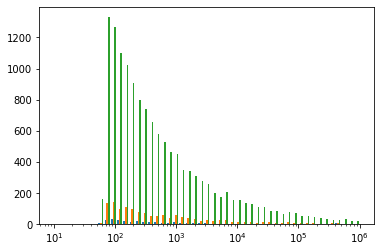

In [27]:
pl.hist([st0stars_L, st1stars_L, st2stars_L], bins=np.logspace(1,6))
pl.semilogx();

In [28]:
geoms

['s---s-i',
 's-pbsmi',
 's-p-hmi',
 'spu-hmi',
 'spubsmi',
 's-pbhmi',
 's-u-smi',
 's-ubhmi',
 'spu-smi',
 's-u-hmi',
 's-ubsmi',
 'sp--hmi',
 'sp--s-i',
 'spubhmi',
 's---smi',
 'sp--smi',
 's-p-smi',
 'sp--h-i']

In [29]:
geom = 'spubhmi'

In [30]:
# Some models do not produce finite fluxes in the specified apertures
color1 = keys1 = 'NIRCam.F212N', 'NIRCam.F480M',
tbs = {cname: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/{cname}.fits')
       for cname in keys1}
apnum = 5
isfinite = np.all([np.isfinite(tbs[key]['TOTAL_FLUX'][:, apnum]) & ~(tbs[key]['TOTAL_FLUX'][:, apnum]).mask
                   for key in keys1], axis=0)
isfinite.sum() / isfinite.size

0.3421680555555556

In [31]:
(classification_dict[geom]['Stage'] == 0).sum(),  ((classification_dict[geom]['Stage'] == 0) & isfinite).sum(), isfinite.sum()

(91993, 17098, 246361)

Text(0.5, 1.0, 'Stage 0 aperture 5')

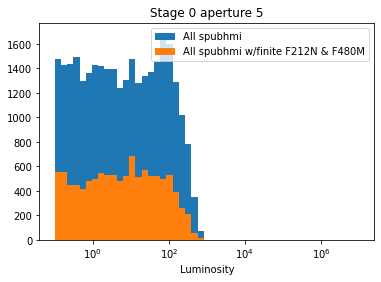

In [32]:
pars = augpars_dict[geom][(classification_dict[geom]['Stage'] == 0)]
pl.hist(pars['Source Luminosity'], bins=np.logspace(-1, 7), label=f'All {geom}');
pars = augpars_dict[geom][(classification_dict[geom]['Stage'] == 0) & isfinite]
pl.hist(pars['Source Luminosity'], bins=np.logspace(-1, 7), label=f'All {geom} w/finite F212N & F480M');
pl.semilogx();
pl.xlabel("Luminosity")
pl.legend(loc='best')
pl.title(f"Stage 0 aperture {apnum}")

In [33]:
set(classification_dict[geom]['Stage'])

{-1, 0, 1, 2, 3}

In [34]:
pars = augpars_dict[geom][(classification_dict[geom]['Stage'] == 0)]
pars[pars['Source Luminosity'] > 1e4]

<Table length=0>
MODEL_NAME star.radius star.temperature disk.mass disk.rmax disk.beta  disk.p disk.h100 envelope.rho_0 envelope.rc ... Sphere Masses Inner Radius Outer Radius Line-of-Sight Mass-Weighted Temperatures Line-of-Sight Photon-Weighted Temperatures Sphere Weighted Temperatures    Av   Disk Minimum Q Spectral Index
                                                                                                                   ...                                                                                                                                                                                               
 bytes20     float64       float64       float64   float64   float64  float64  float64     float64       float64   ... float64[1,20]  float64[1]   float64[1]                float64[20]                               float64[20]                        float64[1,20]         float64   float64[1]    float64[20]  
---------- ----------- ---------------- --------- --------- --------- ------- --------- -------------- ----------- ... ------------- ------------ ------------ ---------------------------------------- ------------------------------------------ ---------------------------- ------- -------------- --------------

Text(0.5, 1.0, 'Stage 1 aperture 5')

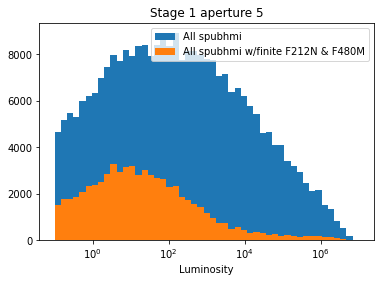

In [35]:
pars = augpars_dict[geom][(classification_dict[geom]['Stage'] == 1)]
pl.hist(pars['Source Luminosity'], bins=np.logspace(-1, 7), label=f'All {geom}');
pars = augpars_dict[geom][(classification_dict[geom]['Stage'] == 1) & isfinite]
pl.hist(pars['Source Luminosity'], bins=np.logspace(-1, 7), label=f'All {geom} w/finite F212N & F480M');
pl.semilogx();
pl.xlabel("Luminosity")
pl.legend(loc='best')
pl.title(f"Stage 1 aperture {apnum}")

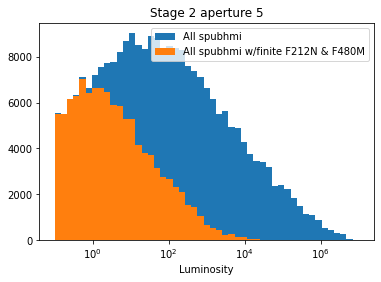

In [36]:
pars = augpars_dict[geom][(classification_dict[geom]['Stage'] == 2)]
pl.hist(pars['Source Luminosity'], bins=np.logspace(-1, 7), label=f'All {geom}');
pars = augpars_dict[geom][(classification_dict[geom]['Stage'] == 2) & isfinite]
pl.hist(pars['Source Luminosity'], bins=np.logspace(-1, 7), label=f'All {geom} w/finite F212N & F480M');
pl.semilogx();
pl.xlabel("Luminosity")
pl.legend(loc='best')
pl.title(f"Stage 2 aperture {apnum}");

In [37]:
pwd

'/orange/adamginsburg/robitaille_models/modelgrids/notebooks'

# Bad hack time here:

`if(any())` in this code means there are stars that are just straight up not included in our model grid - there are no predictions for their JWST fluxes even though they are real models.

In [38]:
pars = augpars_dict[geom][(classification_dict[geom]['Stage'] == 0) & isfinite]
st0models = [np.random.choice(pars['MODEL_NAME'][(0.9 * L < pars['Source Luminosity']) &
                                                 (pars['Source Luminosity'] < 1.1 * L)])
             for L in st0stars_L
            if any((0.9 * L < pars['Source Luminosity']) &
                                                 (pars['Source Luminosity'] < 1.1 * L))]

In [39]:
pars = augpars_dict[geom][(classification_dict[geom]['Stage'] == 1) & isfinite]
st1models = [np.random.choice(pars['MODEL_NAME'][(0.9 * L < pars['Source Luminosity']) &
                                                 (pars['Source Luminosity'] < 1.1 * L)])
             for L in st1stars_L 
             if any((0.9 * L < pars['Source Luminosity']) &
                                                 (pars['Source Luminosity'] < 1.1 * L))
            ]

In [40]:
pars = augpars_dict[geom][(classification_dict[geom]['Stage'] == 2) & isfinite]
st2models = [np.random.choice(pars['MODEL_NAME'][(0.9 * L < pars['Source Luminosity']) &
                                                 (pars['Source Luminosity'] < 1.1 * L)])
             for L in st2stars_L 
             if any((0.9 * L < pars['Source Luminosity']) &
                                                 (pars['Source Luminosity'] < 1.1 * L))
            ]

In [1]:
import dust_extinction
from dust_extinction.averages import RRP89_MWGC, CT06_MWGC, F11_MWGC, G21_MWAvg
from dust_extinction.parameter_averages import CCM89
ext = CT06_MWLoc()

NameError: name 'CT06_MWLoc' is not defined

In [42]:
from astroquery.svo_fps import SvoFps

In [43]:
jfilts = SvoFps.get_filter_list('JWST')
jfilts.add_index('filterID')

In [44]:
distance_modulus = 5 * np.log10(850)
distance_modulus

14.647094628571464

In [45]:
basepath = '/orange/adamginsburg/jwst/brick/'
mist = Table.read(f'{basepath}/isochrones/MIST_iso_633a08f2d8bb1.iso.cmd',
                  header_start=12, data_start=13, format='ascii', delimiter=' ', comment='#')

Stage 0, 195, 195, 195
Stage 1, 1370, 1368, 1370
(4, 10) (6.019175199999999, 13.4739712)


/scratch/local/12219594/ipykernel_173929/3575904288.py:24: RuntimeWarning: divide by zero encountered in log10
  colorp1 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)) +
/scratch/local/12219594/ipykernel_173929/3575904288.py:26: RuntimeWarning: divide by zero encountered in log10
  colorp2 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)))


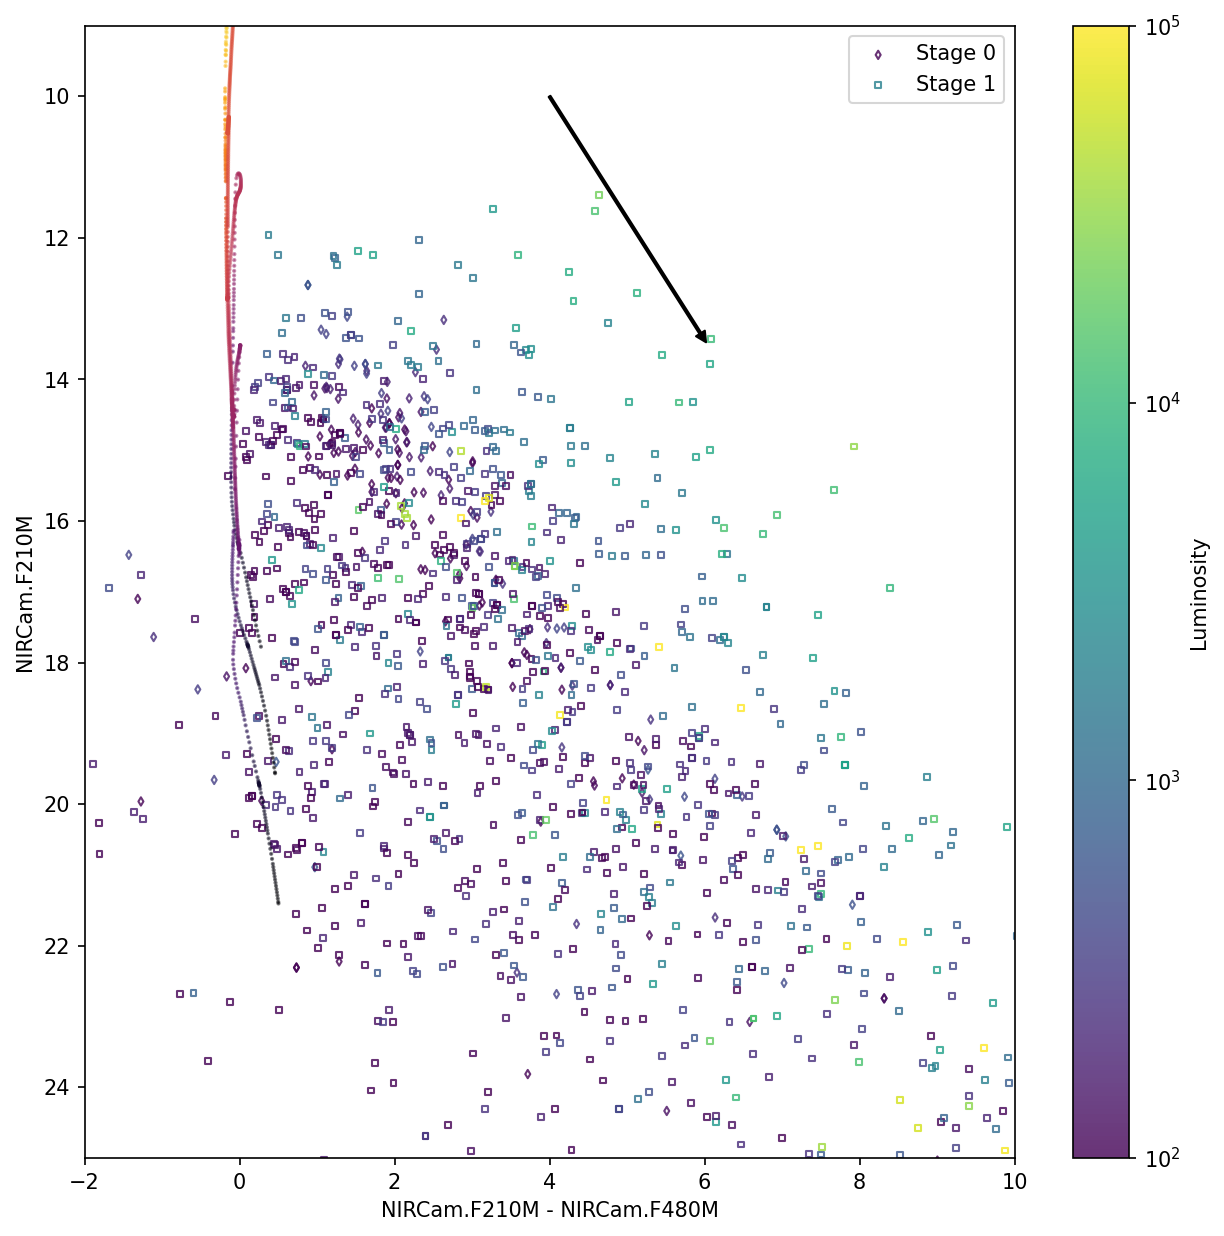

In [46]:
fig = pl.figure(figsize=(10, 10), dpi=150)
ax = pl.gca()

av = 30

cmap = pl.cm.viridis

color1 = keys1 = 'NIRCam.F210M', 'NIRCam.F480M',
tbs = {cname: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/{cname}.fits')
       for cname in keys1}
for tb in tbs.values():
    tb.add_index('MODEL_NAME')
tbs0 = {key: val.loc[np.array(st0models, dtype='unicode')] for key, val in tbs.items()}
tbs1 = {key: val.loc[np.array(st1models, dtype='unicode')] for key, val in tbs.items()}
tbs2 = {key: val.loc[np.array(st2models, dtype='unicode')] for key, val in tbs.items()}

norm = simple_norm(np.hstack([st0stars_L, st1stars_L, st2stars_L]), stretch='log', min_cut=1e2, max_cut=1e5)

pars = augpars_dict[geom]

for tbs, stage, shape, luminosities, mods in zip((tbs0, tbs1, tbs2), (0, 1, 2), ('d', 's', 'o'), (st0stars_L, st1stars_L, st2stars_L), (st0models, st1models, st2models)):
    if stage == 2:
        continue
    colorp1 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)) +
               2.5*np.log10(tbs[keys1[1]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[1]]['ZeroPoint'], u.Jy)))
    colorp2 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)))

    print(f"Stage {stage}, {len(colorp1)}, {np.isfinite(colorp1).sum()}, {np.isfinite(np.array(colorp2)).sum()}")#, {colorp1}, {colorp2}")
    sc = ax.scatter(colorp1, colorp2 + distance_modulus, alpha=0.8,
                    #c=[stage]*len(colorp2),
                    c=pars.loc[np.array(mods, dtype='unicode')]['Source Luminosity'],
                    norm=norm,
                    cmap=cmap,
                    marker=shape,
                    #facecolors='none',
                    #edgecolors=cmap(norm(pars.loc[np.array(mods, dtype='unicode')]['Source Luminosity'])),
                    s=8,
                    label=f'Stage {stage}',
                   )#(np.log10(augpars['Source Luminosity'])))
    pl.draw()
    facecolors = sc.get_facecolors()
    edgecolors = sc.get_edgecolors()
    sc.set_edgecolors(facecolors)
    sc.set_facecolors('none')
#ax.scatter(colorp1[sel], colorp2[sel], s=5, alpha=0.5, c='r')
ax.set_xlabel(f"{color1[0]} - {color1[1]}")
ax.set_ylabel(f"{color1[0]}")
ax.axis((-2,10,25,9))
cb = pl.colorbar(mappable=sc, ax=ax)
cb.set_label('Luminosity')
cb.set_ticks([1e2, 1e3, 1e4, 1e5])
cb.set_ticklabels([f'$10^{x}$' for x in (2,3,4,5)])


norm = simple_norm(mist['initial_mass'][mist['log10_isochrone_age_yr'] < 7], stretch='log')
for age in np.unique(mist['log10_isochrone_age_yr']):
    if age in (5,6,7):
    
        agesel = mist['log10_isochrone_age_yr'] == age
        pl.scatter(-(mist['F480M'][agesel] - mist['F210M'][agesel]),
                   (mist['F210M'])[agesel]+distance_modulus,
                   c=mist['initial_mass'][agesel],
                   norm=norm,
                   cmap='inferno',
                   alpha=0.5,
                   s=1,
                  )


wl1_um = int(color1[0][-4:-1])*u.um/100
wl2_um = int(color1[1][-4:-1])*u.um/100
#wl3_um = int(color2[0][-4:-1])*u.um/100
#wl4_um = int(color2[1][-4:-1])*u.um/100
ext = CT06_MWGC()
extcol1 = av * (ext(wl1_um) - ext(wl2_um))
#extcol2 = av * (ext(wl3_um) - ext(wl4_um))
extcol2 = av * ext(wl1_um)

leg = pl.legend(loc='best')
#for lh in leg.legend_handles:
#    lh.set_facecolors('k')
#    lh.set_edgecolor('k')

arrow_start = (4, 10)
arrow_end = (arrow_start[0] + extcol1, arrow_start[1] + extcol2)
print(arrow_start, arrow_end)
ax.annotate('', arrow_end, arrow_start,
    arrowprops=dict(width=1, headwidth=5, headlength=5,
    edgecolor='k',
    facecolor='k', ),
    color='k',
   );
pl.savefig("SynthesizedFullCMZYSOPopulation.png", bbox_inches='tight')

The plot above includes only "stagified" sources, which means they should be at least semi-realistic (they pass _some_ cuts).

Stage 0, 195, 195, 195
Stage 1, 1370, 1368, 1370
Stage 2, 13055, 13055, 13055


/scratch/local/12219594/ipykernel_173929/4179041903.py:22: RuntimeWarning: divide by zero encountered in log10
  colorp1 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)) +
/scratch/local/12219594/ipykernel_173929/4179041903.py:24: RuntimeWarning: divide by zero encountered in log10
  colorp2 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)))


(4, 10) (6.019175199999999, 13.4739712)


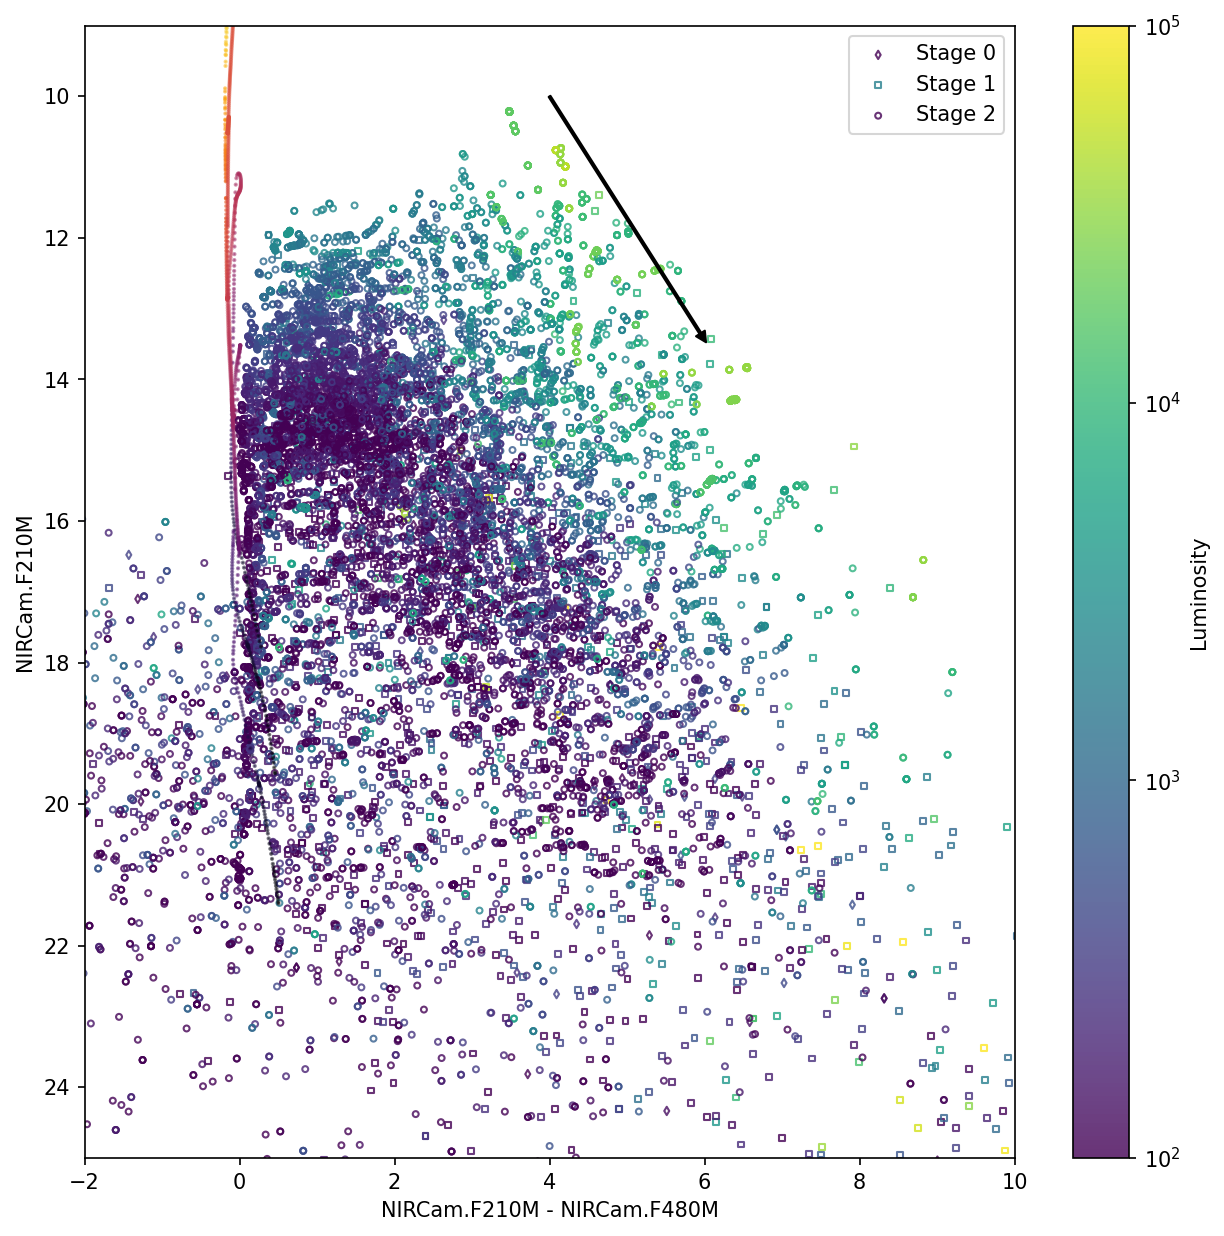

In [47]:

fig = pl.figure(figsize=(10, 10), dpi=150)
ax = pl.gca()

av = 30

cmap = pl.cm.viridis

color1 = keys1 = 'NIRCam.F210M', 'NIRCam.F480M',
tbs = {cname: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/{cname}.fits')
       for cname in keys1}
for tb in tbs.values():
    tb.add_index('MODEL_NAME')
tbs0 = {key: val.loc[np.array(st0models, dtype='unicode')] for key, val in tbs.items()}
tbs1 = {key: val.loc[np.array(st1models, dtype='unicode')] for key, val in tbs.items()}
tbs2 = {key: val.loc[np.array(st2models, dtype='unicode')] for key, val in tbs.items()}

norm = simple_norm(np.hstack([st0stars_L, st1stars_L, st2stars_L]), stretch='log', min_cut=1e2, max_cut=1e5)

pars = augpars_dict[geom]

for tbs, stage, shape, luminosities, mods in zip((tbs0, tbs1, tbs2), (0, 1, 2), ('d', 's', 'o'), (st0stars_L, st1stars_L, st2stars_L), (st0models, st1models, st2models)):
    colorp1 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)) +
               2.5*np.log10(tbs[keys1[1]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[1]]['ZeroPoint'], u.Jy)))
    colorp2 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)))

    print(f"Stage {stage}, {len(colorp1)}, {np.isfinite(colorp1).sum()}, {np.isfinite(np.array(colorp2)).sum()}")#, {colorp1}, {colorp2}")
    sc = ax.scatter(colorp1, colorp2 + distance_modulus, alpha=0.8,
                    #c=[stage]*len(colorp2),
                    c=pars.loc[np.array(mods, dtype='unicode')]['Source Luminosity'],
                    norm=norm,
                    cmap=cmap,
                    marker=shape,
                    #facecolors='none',
                    #edgecolors=cmap(norm(pars.loc[np.array(mods, dtype='unicode')]['Source Luminosity'])),
                    s=8,
                    label=f'Stage {stage}',
                   )#(np.log10(augpars['Source Luminosity'])))
    pl.draw()
    facecolors = sc.get_facecolors()
    edgecolors = sc.get_edgecolors()
    sc.set_edgecolors(facecolors)
    sc.set_facecolors('none')
#ax.scatter(colorp1[sel], colorp2[sel], s=5, alpha=0.5, c='r')
ax.set_xlabel(f"{color1[0]} - {color1[1]}")
ax.set_ylabel(f"{color1[0]}")
ax.axis((-2,10,25,9))
cb = pl.colorbar(mappable=sc, ax=ax)
cb.set_label('Luminosity')
cb.set_ticks([1e2, 1e3, 1e4, 1e5])
cb.set_ticklabels([f'$10^{x}$' for x in (2,3,4,5)])


norm = simple_norm(mist['initial_mass'][mist['log10_isochrone_age_yr'] < 7], stretch='log')
for age in np.unique(mist['log10_isochrone_age_yr']):
    if age in (5,6,7):
    
        agesel = mist['log10_isochrone_age_yr'] == age
        pl.scatter(-(mist['F480M'][agesel] - mist['F210M'][agesel]),
                   (mist['F210M'])[agesel]+distance_modulus,
                   c=mist['initial_mass'][agesel],
                   norm=norm,
                   cmap='inferno',
                   alpha=0.5,
                   s=1,
                  )


wl1_um = int(color1[0][-4:-1])*u.um/100
wl2_um = int(color1[1][-4:-1])*u.um/100
#wl3_um = int(color2[0][-4:-1])*u.um/100
#wl4_um = int(color2[1][-4:-1])*u.um/100
ext = CT06_MWGC()
extcol1 = av * (ext(wl1_um) - ext(wl2_um))
#extcol2 = av * (ext(wl3_um) - ext(wl4_um))
extcol2 = av * ext(wl1_um)

leg = pl.legend(loc='best')
#for lh in leg.legend_handles:
#    lh.set_facecolors('k')
#    lh.set_edgecolor('k')

arrow_start = (4, 10)
arrow_end = (arrow_start[0] + extcol1, arrow_start[1] + extcol2)
print(arrow_start, arrow_end)
ax.annotate('', arrow_end, arrow_start,
    arrowprops=dict(width=1, headwidth=5, headlength=5,
    edgecolor='k',
    facecolor='k', ),
    color='k',
   );
pl.savefig("SynthesizedFullCMZYSOPopulation_withStageII.png", bbox_inches='tight')

In [48]:
from astropy import constants, units as u

In [49]:
Lacc = (constants.G * 5e-6*u.M_sun/u.yr * u.M_sun / u.R_sun).to(u.Lsun)
Lacc

<Quantity 156.99638381 solLum>

Stage 0, 195, 195, 195
Stage 1, 1370, 1370, 1370
Stage 2, 13055, 13055, 13055
(4, 10) (4.1914359999999995, 11.454796)


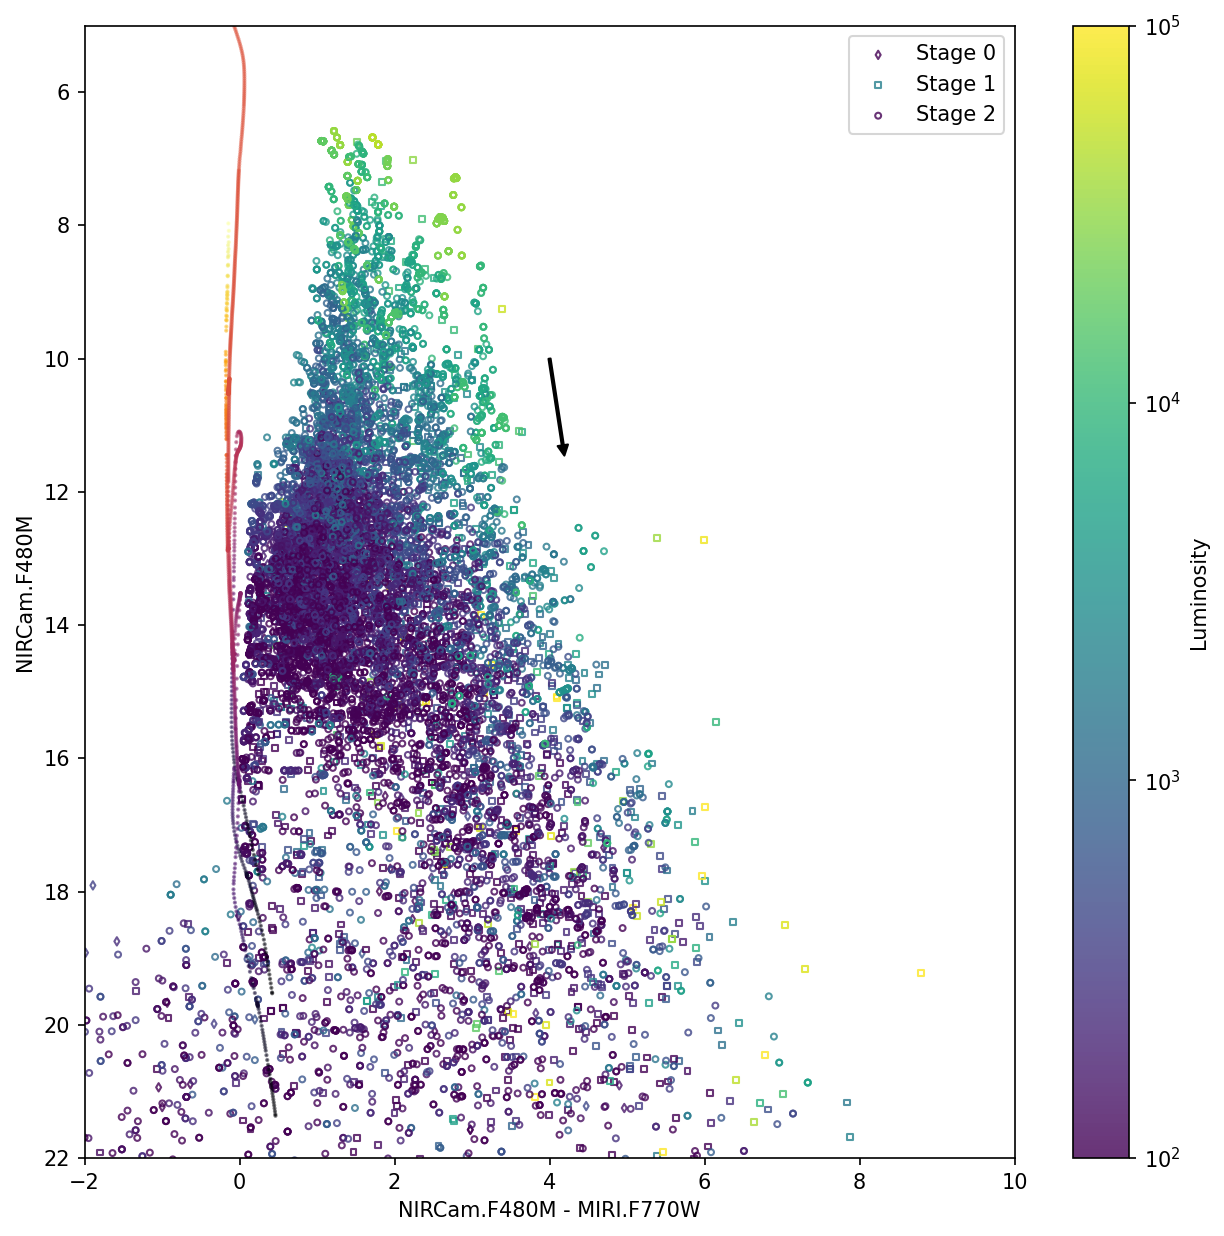

In [50]:

fig = pl.figure(figsize=(10, 10), dpi=150)
ax = pl.gca()

av = 30

cmap = pl.cm.viridis

color1 = keys1 = 'NIRCam.F480M', 'MIRI.F770W'
tbs = {cname: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/{cname}.fits')
       for cname in keys1}
for tb in tbs.values():
    tb.add_index('MODEL_NAME')
tbs0 = {key: val.loc[np.array(st0models, dtype='unicode')] for key, val in tbs.items()}
tbs1 = {key: val.loc[np.array(st1models, dtype='unicode')] for key, val in tbs.items()}
tbs2 = {key: val.loc[np.array(st2models, dtype='unicode')] for key, val in tbs.items()}

norm = simple_norm(np.hstack([st0stars_L, st1stars_L, st2stars_L]), stretch='log', min_cut=1e2, max_cut=1e5)

pars = augpars_dict[geom]

for tbs, stage, shape, luminosities, mods in zip((tbs0, tbs1, tbs2), (0, 1, 2), ('d', 's', 'o'), (st0stars_L, st1stars_L, st2stars_L), (st0models, st1models, st2models)):
    colorp1 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)) +
               2.5*np.log10(tbs[keys1[1]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[1]]['ZeroPoint'], u.Jy)))
    colorp2 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)))

    print(f"Stage {stage}, {len(colorp1)}, {np.isfinite(colorp1).sum()}, {np.isfinite(np.array(colorp2)).sum()}")#, {colorp1}, {colorp2}")
    sc = ax.scatter(colorp1, colorp2 + distance_modulus, alpha=0.8,
                    #c=[stage]*len(colorp2),
                    c=pars.loc[np.array(mods, dtype='unicode')]['Source Luminosity'],
                    norm=norm,
                    cmap=cmap,
                    marker=shape,
                    #facecolors='none',
                    #edgecolors=cmap(norm(pars.loc[np.array(mods, dtype='unicode')]['Source Luminosity'])),
                    s=8,
                    label=f'Stage {stage}',
                   )#(np.log10(augpars['Source Luminosity'])))
    pl.draw()
    facecolors = sc.get_facecolors()
    edgecolors = sc.get_edgecolors()
    sc.set_edgecolors(facecolors)
    sc.set_facecolors('none')
#ax.scatter(colorp1[sel], colorp2[sel], s=5, alpha=0.5, c='r')
ax.set_xlabel(f"{color1[0]} - {color1[1]}")
ax.set_ylabel(f"{color1[0]}")
ax.axis((-2,10,22,5))
cb = pl.colorbar(mappable=sc, ax=ax)
cb.set_label('Luminosity')
cb.set_ticks([1e2, 1e3, 1e4, 1e5])
cb.set_ticklabels([f'$10^{x}$' for x in (2,3,4,5)])


norm = simple_norm(mist['initial_mass'][mist['log10_isochrone_age_yr'] < 7], stretch='log')
for age in np.unique(mist['log10_isochrone_age_yr']):
    if age in (5,6,7):
    
        agesel = mist['log10_isochrone_age_yr'] == age
        pl.scatter(-(mist['F480M'][agesel] - mist['F212N'][agesel]),
                   (mist['F212N'])[agesel]+distance_modulus,
                   c=mist['initial_mass'][agesel],
                   norm=norm,
                   cmap='inferno',
                   alpha=0.5,
                   s=1,
                  )


wl1_um = int(color1[0][-4:-1])*u.um/100
wl2_um = int(color1[1][-4:-1])*u.um/100
#wl3_um = int(color2[0][-4:-1])*u.um/100
#wl4_um = int(color2[1][-4:-1])*u.um/100
ext = CT06_MWGC()
extcol1 = av * (ext(wl1_um) - ext(wl2_um))
#extcol2 = av * (ext(wl3_um) - ext(wl4_um))
extcol2 = av * ext(wl1_um)

leg = pl.legend(loc='best')
#for lh in leg.legend_handles:
#    lh.set_facecolors('k')
#    lh.set_edgecolor('k')

arrow_start = (4, 10)
arrow_end = (arrow_start[0] + extcol1, arrow_start[1] + extcol2)
print(arrow_start, arrow_end)
ax.annotate('', arrow_end, arrow_start,
    arrowprops=dict(width=1, headwidth=5, headlength=5,
    edgecolor='k',
    facecolor='k', ),
    color='k',
   );
pl.savefig("SynthesizedFullCMZYSOPopulation_withStageII_MIRIF770W.png", bbox_inches='tight')

Stage 0, 195, 195, 195
Stage 1, 1370, 1370, 1370
Stage 2, 13055, 13055, 13055
(4, 10) (4.1068071999999995, 11.454796)


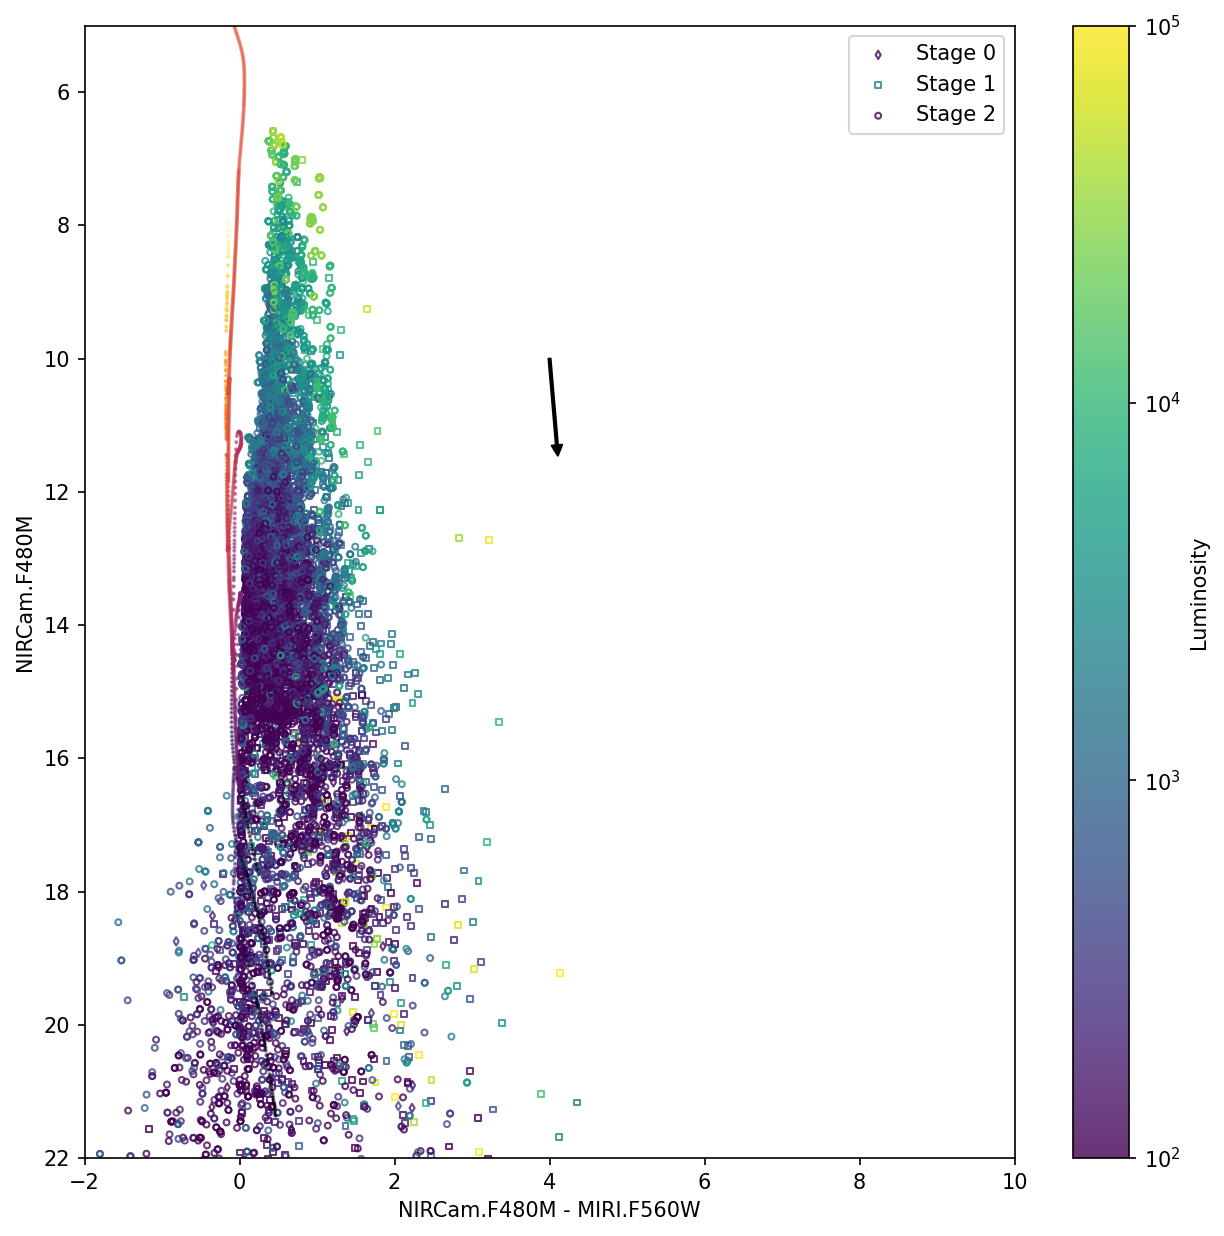

In [51]:

fig = pl.figure(figsize=(10, 10), dpi=150)
ax = pl.gca()

av = 30

cmap = pl.cm.viridis

color1 = keys1 = 'NIRCam.F480M', 'MIRI.F560W'
tbs = {cname: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/{cname}.fits')
       for cname in keys1}
for tb in tbs.values():
    tb.add_index('MODEL_NAME')
tbs0 = {key: val.loc[np.array(st0models, dtype='unicode')] for key, val in tbs.items()}
tbs1 = {key: val.loc[np.array(st1models, dtype='unicode')] for key, val in tbs.items()}
tbs2 = {key: val.loc[np.array(st2models, dtype='unicode')] for key, val in tbs.items()}

norm = simple_norm(np.hstack([st0stars_L, st1stars_L, st2stars_L]), stretch='log', min_cut=1e2, max_cut=1e5)

pars = augpars_dict[geom]

for tbs, stage, shape, luminosities, mods in zip((tbs0, tbs1, tbs2), (0, 1, 2), ('d', 's', 'o'), (st0stars_L, st1stars_L, st2stars_L), (st0models, st1models, st2models)):
    colorp1 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)) +
               2.5*np.log10(tbs[keys1[1]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[1]]['ZeroPoint'], u.Jy)))
    colorp2 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)))

    print(f"Stage {stage}, {len(colorp1)}, {np.isfinite(colorp1).sum()}, {np.isfinite(np.array(colorp2)).sum()}")#, {colorp1}, {colorp2}")
    sc = ax.scatter(colorp1, colorp2 + distance_modulus, alpha=0.8,
                    #c=[stage]*len(colorp2),
                    c=pars.loc[np.array(mods, dtype='unicode')]['Source Luminosity'],
                    norm=norm,
                    cmap=cmap,
                    marker=shape,
                    #facecolors='none',
                    #edgecolors=cmap(norm(pars.loc[np.array(mods, dtype='unicode')]['Source Luminosity'])),
                    s=8,
                    label=f'Stage {stage}',
                   )#(np.log10(augpars['Source Luminosity'])))
    pl.draw()
    facecolors = sc.get_facecolors()
    edgecolors = sc.get_edgecolors()
    sc.set_edgecolors(facecolors)
    sc.set_facecolors('none')
#ax.scatter(colorp1[sel], colorp2[sel], s=5, alpha=0.5, c='r')
ax.set_xlabel(f"{color1[0]} - {color1[1]}")
ax.set_ylabel(f"{color1[0]}")
ax.axis((-2,10,22,5))
cb = pl.colorbar(mappable=sc, ax=ax)
cb.set_label('Luminosity')
cb.set_ticks([1e2, 1e3, 1e4, 1e5])
cb.set_ticklabels([f'$10^{x}$' for x in (2,3,4,5)])


norm = simple_norm(mist['initial_mass'][mist['log10_isochrone_age_yr'] < 7], stretch='log')
for age in np.unique(mist['log10_isochrone_age_yr']):
    if age in (5,6,7):
    
        agesel = mist['log10_isochrone_age_yr'] == age
        pl.scatter(-(mist['F480M'][agesel] - mist['F212N'][agesel]),
                   (mist['F212N'])[agesel]+distance_modulus,
                   c=mist['initial_mass'][agesel],
                   norm=norm,
                   cmap='inferno',
                   alpha=0.5,
                   s=1,
                  )


wl1_um = int(color1[0][-4:-1])*u.um/100
wl2_um = int(color1[1][-4:-1])*u.um/100
#wl3_um = int(color2[0][-4:-1])*u.um/100
#wl4_um = int(color2[1][-4:-1])*u.um/100
ext = CT06_MWGC()
extcol1 = av * (ext(wl1_um) - ext(wl2_um))
#extcol2 = av * (ext(wl3_um) - ext(wl4_um))
extcol2 = av * ext(wl1_um)

leg = pl.legend(loc='best')
#for lh in leg.legend_handles:
#    lh.set_facecolors('k')
#    lh.set_edgecolor('k')

arrow_start = (4, 10)
arrow_end = (arrow_start[0] + extcol1, arrow_start[1] + extcol2)
print(arrow_start, arrow_end)
ax.annotate('', arrow_end, arrow_start,
    arrowprops=dict(width=1, headwidth=5, headlength=5,
    edgecolor='k',
    facecolor='k', ),
    color='k',
   );
pl.savefig("SynthesizedFullCMZYSOPopulation_withStageII_MIRIF560W.png", bbox_inches='tight')

In [52]:
F11_MWGC()(10*u.um)

0.08065064808859979

Stage 0, 195, 195, 195
Stage 1, 1370, 1370, 1370
Stage 2, 13055, 13055, 13055
(4, 10) (4.1068071999999995, 11.454796)


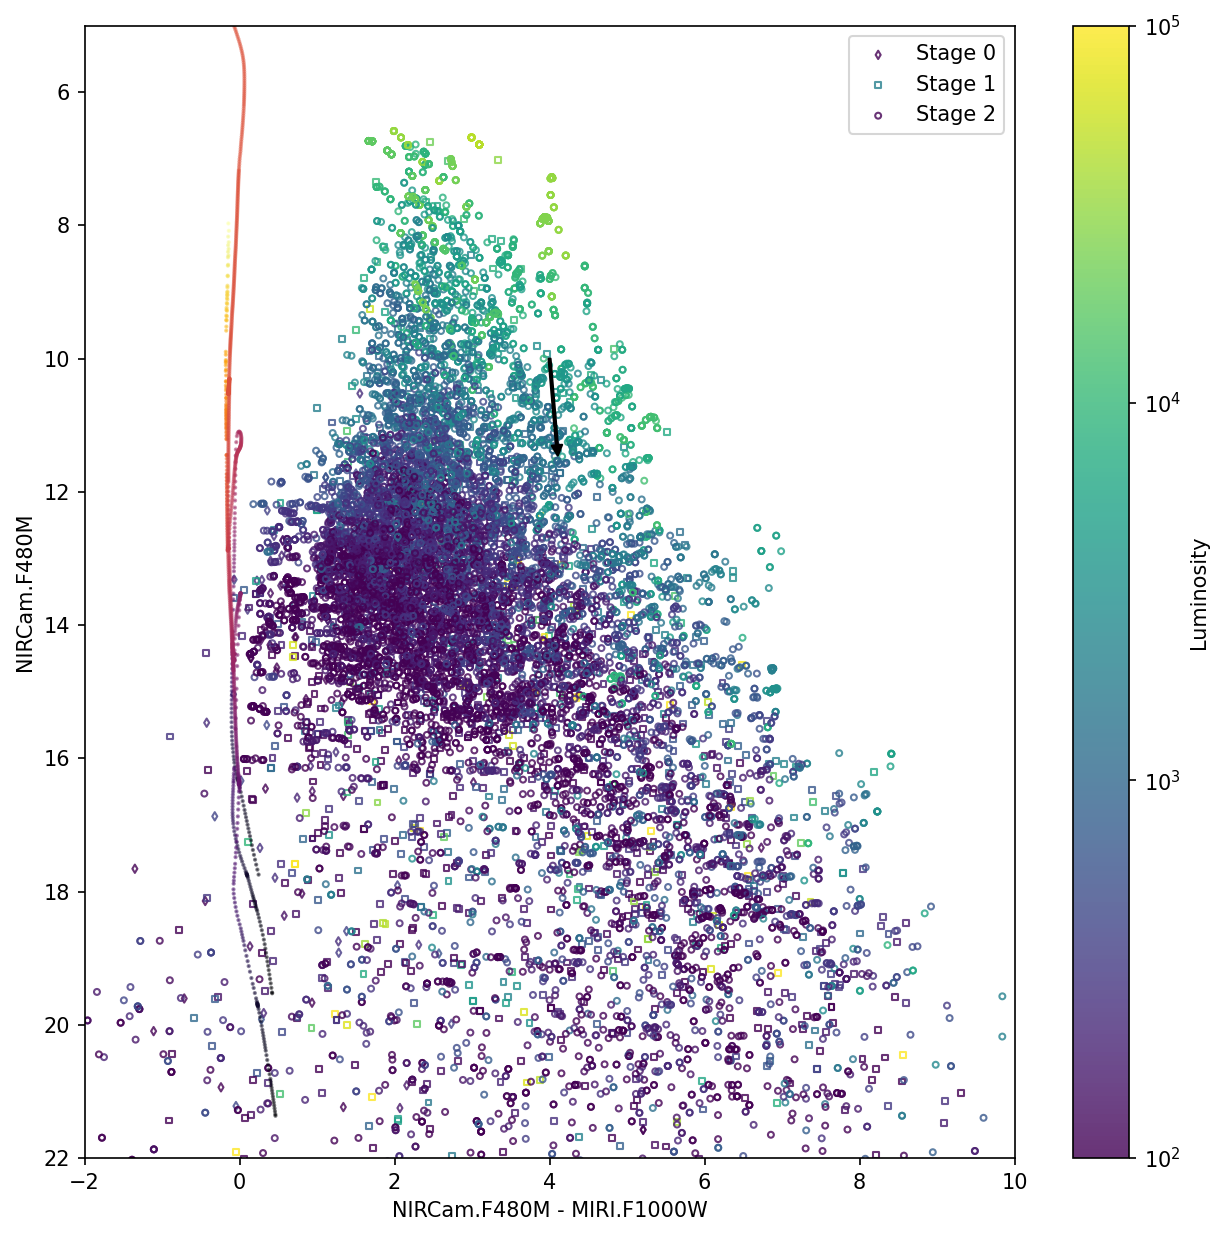

In [53]:

fig = pl.figure(figsize=(10, 10), dpi=150)
ax = pl.gca()

av = 30

cmap = pl.cm.viridis

color1 = keys1 = 'NIRCam.F480M', 'MIRI.F1000W'
tbs = {cname: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/{cname}.fits')
       for cname in keys1}
for tb in tbs.values():
    tb.add_index('MODEL_NAME')
tbs0 = {key: val.loc[np.array(st0models, dtype='unicode')] for key, val in tbs.items()}
tbs1 = {key: val.loc[np.array(st1models, dtype='unicode')] for key, val in tbs.items()}
tbs2 = {key: val.loc[np.array(st2models, dtype='unicode')] for key, val in tbs.items()}

norm = simple_norm(np.hstack([st0stars_L, st1stars_L, st2stars_L]), stretch='log', min_cut=1e2, max_cut=1e5)

pars = augpars_dict[geom]

for tbs, stage, shape, luminosities, mods in zip((tbs0, tbs1, tbs2), (0, 1, 2), ('d', 's', 'o'), (st0stars_L, st1stars_L, st2stars_L), (st0models, st1models, st2models)):
    colorp1 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)) +
               2.5*np.log10(tbs[keys1[1]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[1]]['ZeroPoint'], u.Jy)))
    colorp2 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)))

    print(f"Stage {stage}, {len(colorp1)}, {np.isfinite(colorp1).sum()}, {np.isfinite(np.array(colorp2)).sum()}")#, {colorp1}, {colorp2}")
    sc = ax.scatter(colorp1, colorp2 + distance_modulus, alpha=0.8,
                    #c=[stage]*len(colorp2),
                    c=pars.loc[np.array(mods, dtype='unicode')]['Source Luminosity'],
                    norm=norm,
                    cmap=cmap,
                    marker=shape,
                    #facecolors='none',
                    #edgecolors=cmap(norm(pars.loc[np.array(mods, dtype='unicode')]['Source Luminosity'])),
                    s=8,
                    label=f'Stage {stage}',
                   )#(np.log10(augpars['Source Luminosity'])))
    pl.draw()
    facecolors = sc.get_facecolors()
    edgecolors = sc.get_edgecolors()
    sc.set_edgecolors(facecolors)
    sc.set_facecolors('none')
#ax.scatter(colorp1[sel], colorp2[sel], s=5, alpha=0.5, c='r')
ax.set_xlabel(f"{color1[0]} - {color1[1]}")
ax.set_ylabel(f"{color1[0]}")
ax.axis((-2,10,22,5))
cb = pl.colorbar(mappable=sc, ax=ax)
cb.set_label('Luminosity')
cb.set_ticks([1e2, 1e3, 1e4, 1e5])
cb.set_ticklabels([f'$10^{x}$' for x in (2,3,4,5)])


norm = simple_norm(mist['initial_mass'][mist['log10_isochrone_age_yr'] < 7], stretch='log')
for age in np.unique(mist['log10_isochrone_age_yr']):
    if age in (5,6,7):
    
        agesel = mist['log10_isochrone_age_yr'] == age
        pl.scatter(-(mist['F480M'][agesel] - mist['F212N'][agesel]),
                   (mist['F212N'])[agesel]+distance_modulus,
                   c=mist['initial_mass'][agesel],
                   norm=norm,
                   cmap='inferno',
                   alpha=0.5,
                   s=1,
                  )


wl1_um = int(color1[0][-4:-1])*u.um/100
wl2_um = int(color1[1][-4:-1])*u.um/100
#wl3_um = int(color2[0][-4:-1])*u.um/100
#wl4_um = int(color2[1][-4:-1])*u.um/100
# ext = F11_MWGC()
# extcol1 = av * (ext(wl1_um) - ext(wl2_um))
# #extcol2 = av * (ext(wl3_um) - ext(wl4_um))
# extcol2 = av * ext(wl1_um)

leg = pl.legend(loc='best')
#for lh in leg.legend_handles:
#    lh.set_facecolors('k')
#    lh.set_edgecolor('k')

arrow_start = (4, 10)
arrow_end = (arrow_start[0] + extcol1, arrow_start[1] + extcol2)
print(arrow_start, arrow_end)
ax.annotate('', arrow_end, arrow_start,
    arrowprops=dict(width=1, headwidth=5, headlength=5,
    edgecolor='k',
    facecolor='k', ),
    color='k',
   );
pl.savefig("SynthesizedFullCMZYSOPopulation_withStageII_MIRIF1000W.png", bbox_inches='tight')

Stage 0, 195, 195, 195
Stage 1, 1370, 1370, 1370
Stage 2, 13055, 13055, 13055
(4, 10) (4.1068071999999995, 11.454796)


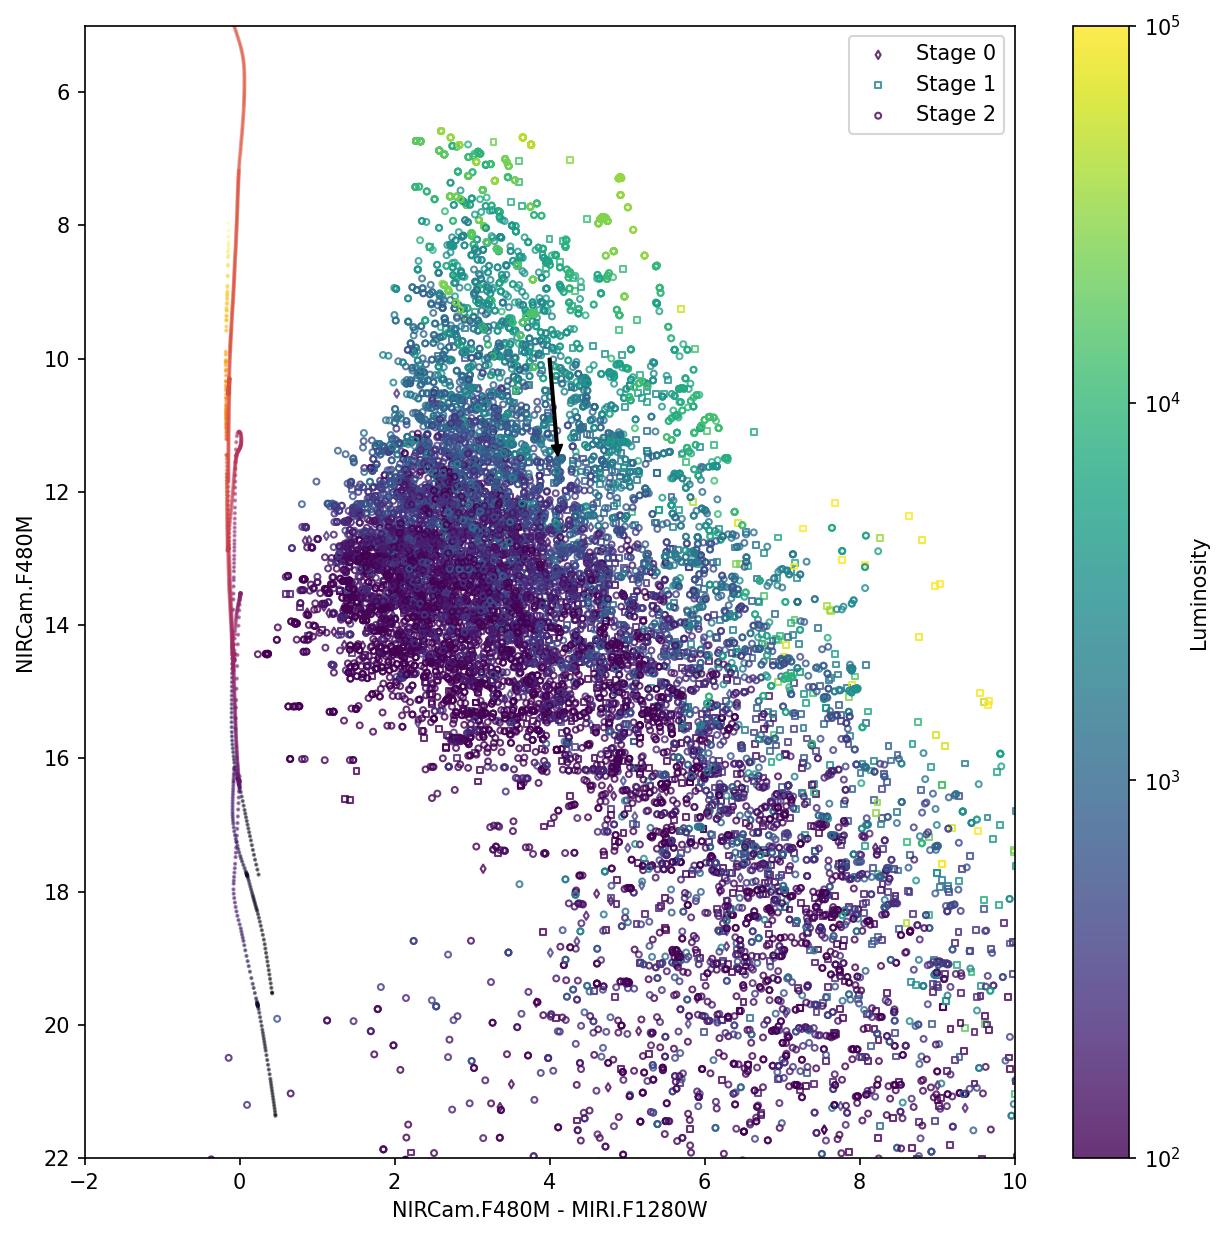

In [54]:

fig = pl.figure(figsize=(10, 10), dpi=150)
ax = pl.gca()

av = 30

cmap = pl.cm.viridis

color1 = keys1 = 'NIRCam.F480M', 'MIRI.F1280W'
tbs = {cname: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/{cname}.fits')
       for cname in keys1}
for tb in tbs.values():
    tb.add_index('MODEL_NAME')
tbs0 = {key: val.loc[np.array(st0models, dtype='unicode')] for key, val in tbs.items()}
tbs1 = {key: val.loc[np.array(st1models, dtype='unicode')] for key, val in tbs.items()}
tbs2 = {key: val.loc[np.array(st2models, dtype='unicode')] for key, val in tbs.items()}

norm = simple_norm(np.hstack([st0stars_L, st1stars_L, st2stars_L]), stretch='log', min_cut=1e2, max_cut=1e5)

pars = augpars_dict[geom]

for tbs, stage, shape, luminosities, mods in zip((tbs0, tbs1, tbs2), (0, 1, 2), ('d', 's', 'o'), (st0stars_L, st1stars_L, st2stars_L), (st0models, st1models, st2models)):
    colorp1 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)) +
               2.5*np.log10(tbs[keys1[1]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[1]]['ZeroPoint'], u.Jy)))
    colorp2 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)))

    print(f"Stage {stage}, {len(colorp1)}, {np.isfinite(colorp1).sum()}, {np.isfinite(np.array(colorp2)).sum()}")#, {colorp1}, {colorp2}")
    sc = ax.scatter(colorp1, colorp2 + distance_modulus, alpha=0.8,
                    #c=[stage]*len(colorp2),
                    c=pars.loc[np.array(mods, dtype='unicode')]['Source Luminosity'],
                    norm=norm,
                    cmap=cmap,
                    marker=shape,
                    #facecolors='none',
                    #edgecolors=cmap(norm(pars.loc[np.array(mods, dtype='unicode')]['Source Luminosity'])),
                    s=8,
                    label=f'Stage {stage}',
                   )#(np.log10(augpars['Source Luminosity'])))
    pl.draw()
    facecolors = sc.get_facecolors()
    edgecolors = sc.get_edgecolors()
    sc.set_edgecolors(facecolors)
    sc.set_facecolors('none')
#ax.scatter(colorp1[sel], colorp2[sel], s=5, alpha=0.5, c='r')
ax.set_xlabel(f"{color1[0]} - {color1[1]}")
ax.set_ylabel(f"{color1[0]}")
ax.axis((-2,10,22,5))
cb = pl.colorbar(mappable=sc, ax=ax)
cb.set_label('Luminosity')
cb.set_ticks([1e2, 1e3, 1e4, 1e5])
cb.set_ticklabels([f'$10^{x}$' for x in (2,3,4,5)])


norm = simple_norm(mist['initial_mass'][mist['log10_isochrone_age_yr'] < 7], stretch='log')
for age in np.unique(mist['log10_isochrone_age_yr']):
    if age in (5,6,7):
    
        agesel = mist['log10_isochrone_age_yr'] == age
        pl.scatter(-(mist['F480M'][agesel] - mist['F212N'][agesel]),
                   (mist['F212N'])[agesel]+distance_modulus,
                   c=mist['initial_mass'][agesel],
                   norm=norm,
                   cmap='inferno',
                   alpha=0.5,
                   s=1,
                  )


wl1_um = int(color1[0][-4:-1])*u.um/100
wl2_um = int(color1[1][-4:-1])*u.um/100
#wl3_um = int(color2[0][-4:-1])*u.um/100
#wl4_um = int(color2[1][-4:-1])*u.um/100
# ext = F11_MWGC()
# extcol1 = av * (ext(wl1_um) - ext(wl2_um))
# #extcol2 = av * (ext(wl3_um) - ext(wl4_um))
# extcol2 = av * ext(wl1_um)

leg = pl.legend(loc='best')
#for lh in leg.legend_handles:
#    lh.set_facecolors('k')
#    lh.set_edgecolor('k')

arrow_start = (4, 10)
arrow_end = (arrow_start[0] + extcol1, arrow_start[1] + extcol2)
print(arrow_start, arrow_end)
ax.annotate('', arrow_end, arrow_start,
    arrowprops=dict(width=1, headwidth=5, headlength=5,
    edgecolor='k',
    facecolor='k', ),
    color='k',
   );
pl.savefig("SynthesizedFullCMZYSOPopulation_withStageII_MIRIF1280W.png", bbox_inches='tight')

In [55]:
parsec_miri = Table.read(f'{basepath}/isochrones/parsec_MIRI_isochrones.dat', 
                         header_start=13, data_start=14, format='ascii', delimiter=' ')
parsec_miri[:3]

<Table length=3>
  Zini     MH    logAge     Mini       int_IMF      Mass    logL   logTe    logg  label McoreTP   C_O   period0 period1 period2 period3 period4 pmode ...    X       Y       Xc        Xn       Xo    Cexcess    Z    mbolmag F560Wmag F770Wmag F1000Wmag F1130Wmag F1280Wmag F1500Wmag F1800Wmag F2100Wmag F2550Wmag
float64 float64 float64   float64      float64    float64 float64 float64 float64 int64 float64 float64 float64 float64 float64 float64 float64 int64 ... float64 float64 float64   float64  float64  float64 float64 float64 float64  float64   float64   float64   float64   float64   float64   float64   float64 
------- ------- ------- ------------ ------------ ------- ------- ------- ------- ----- ------- ------- ------- ------- ------- ------- ------- ----- ... ------- ------- -------- --------- -------- ------- ------- ------- -------- -------- --------- --------- --------- --------- --------- --------- ---------
 0.0152 0.01508     5.0 0.2994569838 1.9518252078   0.299   0.114  3.5519   2.959     0     0.0   0.545     0.0     0.0     0.0     0.0     0.0    -1 ...  0.7092  0.2755 0.002746 0.0007408 0.006719    -1.0 0.01527   4.484    1.515     1.46     1.651     1.832      1.49     1.127     1.022      1.21     0.766
 0.0152 0.01508     5.0 0.3000000119 1.9529139769     0.3   0.116  3.5521   2.959     0     0.0   0.545     0.0     0.0     0.0     0.0     0.0    -1 ...  0.7092  0.2755 0.002746 0.0007408 0.006719    -1.0 0.01527    4.48    1.513    1.457     1.648      1.83     1.488     1.124      1.02     1.208     0.764
 0.0152 0.01508     5.0 0.3163242936 1.9844954655   0.316   0.158  3.5578   2.963     0     0.0   0.545     0.0     0.0     0.0     0.0     0.0    -1 ...  0.7092  0.2755 0.002746 0.0007408 0.006719    -1.0 0.01527   4.375    1.441    1.381     1.577      1.76     1.418     1.054     0.951     1.141     0.697

In [56]:
parsec_nircam = Table.read(f'{basepath}/isochrones/parsec_NIRCam_isochrones.dat', 
                          header_start=13, data_start=14, format='ascii', delimiter=' ')
parsec_nircam[:5]

<Table length=5>
  Zini     MH    logAge     Mini       int_IMF      Mass    logL   logTe    logg  label McoreTP   C_O   period0 period1 period2 period3 period4 pmode ... F277Wmag F356Wmag F444Wmag F150W2mag F322W2mag F140Mmag F162Mmag F182Mmag F210Mmag F250Mmag F300Mmag F335Mmag F360Mmag F410Mmag F430Mmag F460Mmag F480Mmag
float64 float64 float64   float64      float64    float64 float64 float64 float64 int64 float64 float64 float64 float64 float64 float64 float64 int64 ... float64  float64  float64   float64   float64  float64  float64  float64  float64  float64  float64  float64  float64  float64  float64  float64  float64 
------- ------- ------- ------------ ------------ ------- ------- ------- ------- ----- ------- ------- ------- ------- ------- ------- ------- ----- ... -------- -------- -------- --------- --------- -------- -------- -------- -------- -------- -------- -------- -------- -------- -------- -------- --------
 0.0152 0.01508     5.0 0.2994569838 1.9518252078   0.299   0.114  3.5519   2.959     0     0.0   0.545     0.0     0.0     0.0     0.0     0.0    -1 ...    1.757    1.516    1.519     2.169     1.644    2.315    1.766    1.682    1.625    1.872    1.675    1.554    1.483    1.445    1.485    1.622    1.599
 0.0152 0.01508     5.0 0.3000000119 1.9529139769     0.3   0.116  3.5521   2.959     0     0.0   0.545     0.0     0.0     0.0     0.0     0.0    -1 ...    1.754    1.513    1.517     2.166     1.641    2.312    1.763    1.679    1.622    1.869    1.672    1.552    1.481    1.443    1.483     1.62    1.597
 0.0152 0.01508     5.0 0.3163242936 1.9844954655   0.316   0.158  3.5578   2.963     0     0.0   0.545     0.0     0.0     0.0     0.0     0.0    -1 ...    1.655    1.434    1.448     2.079     1.552     2.22     1.68    1.588    1.536    1.772    1.571    1.466    1.406    1.374    1.413    1.551    1.527
 0.0152 0.01508     5.0 0.3500000238 2.0434175133    0.35   0.237  3.5688   2.973     0     0.0   0.545     0.0     0.0     0.0     0.0     0.0    -1 ...    1.478    1.294    1.324      1.92     1.393    2.054    1.526    1.425    1.382    1.596    1.395    1.315    1.274    1.251    1.288    1.426    1.402
 0.0152 0.01508     5.0 0.3837943673 2.0955676574   0.384   0.312  3.5783   2.975     0     0.0   0.545     0.0     0.0     0.0     0.0     0.0    -1 ...    1.313    1.156    1.197     1.766     1.241    1.892    1.378    1.274    1.235    1.429    1.232    1.171    1.143    1.125    1.161    1.299    1.274

Stage 0, 195, 195, 195
Stage 1, 1370, 1368, 1370
Stage 2, 13055, 13055, 13055


/scratch/local/12219594/ipykernel_173929/3583888966.py:23: RuntimeWarning: divide by zero encountered in log10
  colorp1 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)) +


(0, 0) (2.0191751999999994, -0.8064840000000004)


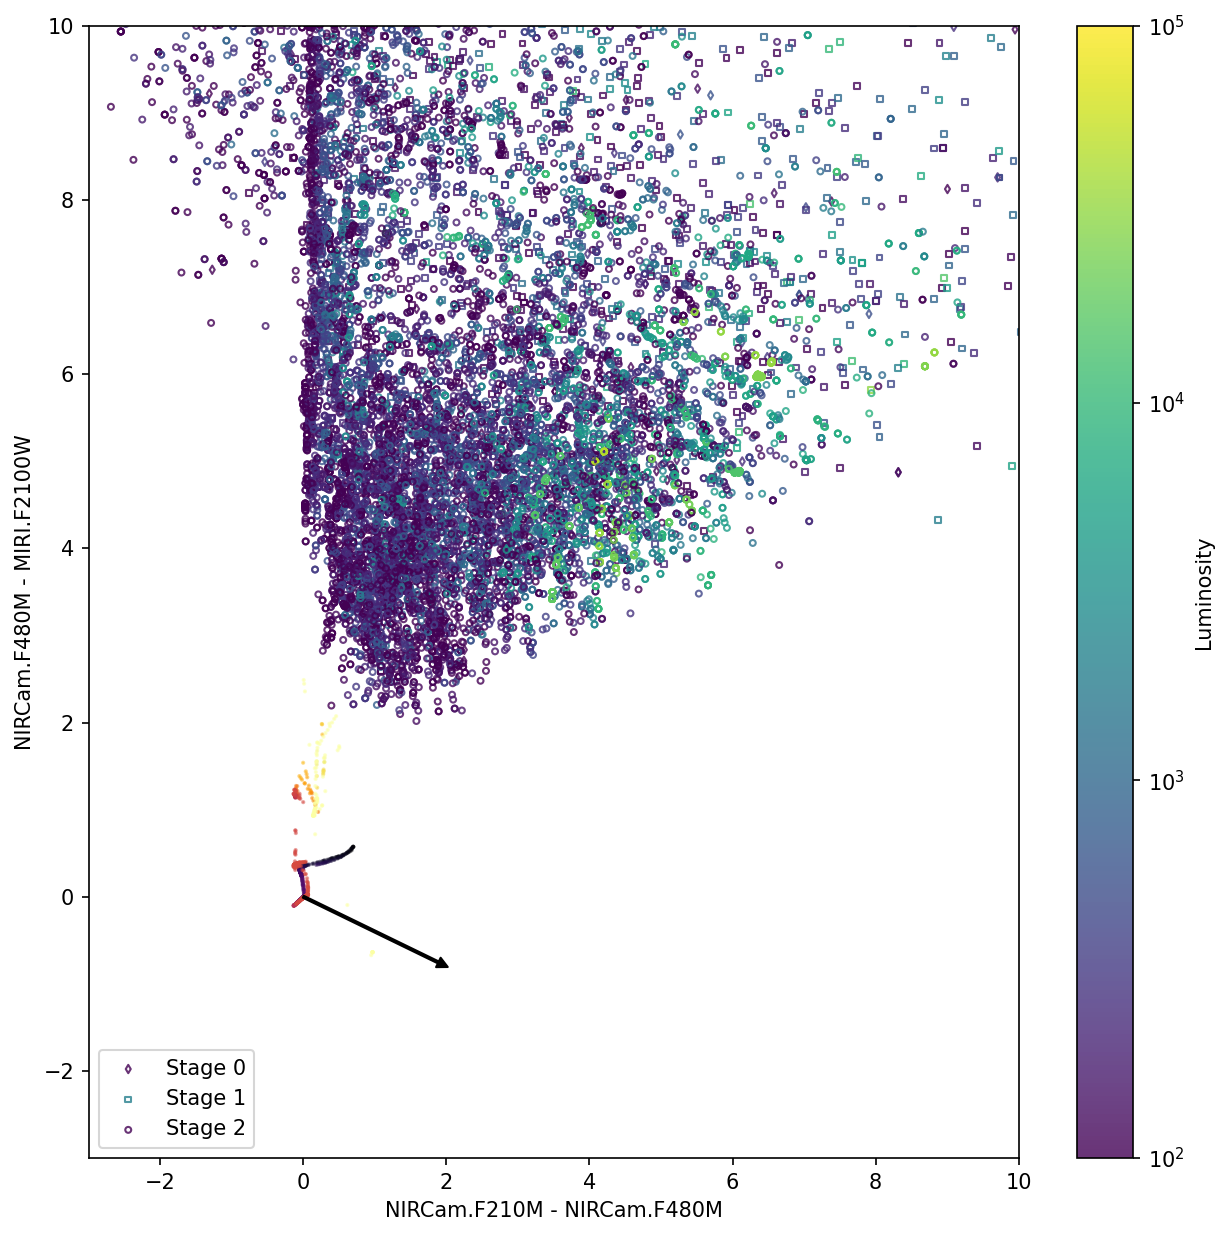

In [57]:

fig = pl.figure(figsize=(10, 10), dpi=150)
ax = pl.gca()

av = 30

cmap = pl.cm.viridis

color1 = keys1 = 'NIRCam.F210M', 'NIRCam.F480M'
color2 = keys2 = 'NIRCam.F480M', 'MIRI.F2100W'
tbs = {cname: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/{cname}.fits')
       for cname in set(keys1+keys2)}
for tb in tbs.values():
    tb.add_index('MODEL_NAME')
tbs0 = {key: val.loc[np.array(st0models, dtype='unicode')] for key, val in tbs.items()}
tbs1 = {key: val.loc[np.array(st1models, dtype='unicode')] for key, val in tbs.items()}
tbs2 = {key: val.loc[np.array(st2models, dtype='unicode')] for key, val in tbs.items()}

norm = simple_norm(np.hstack([st0stars_L, st1stars_L, st2stars_L]), stretch='log', min_cut=1e2, max_cut=1e5)

pars = augpars_dict[geom]

for tbs, stage, shape, luminosities, mods in zip((tbs0, tbs1, tbs2), (0, 1, 2), ('d', 's', 'o'), (st0stars_L, st1stars_L, st2stars_L), (st0models, st1models, st2models)):
    colorp1 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)) +
               2.5*np.log10(tbs[keys1[1]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[1]]['ZeroPoint'], u.Jy)))
    colorp2 = (-2.5*np.log10(tbs[keys2[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys2[0]]['ZeroPoint'], u.Jy)) +
               2.5*np.log10(tbs[keys2[1]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys2[1]]['ZeroPoint'], u.Jy)))

    print(f"Stage {stage}, {len(colorp1)}, {np.isfinite(colorp1).sum()}, {np.isfinite(np.array(colorp2)).sum()}")#, {colorp1}, {colorp2}")
    sc = ax.scatter(colorp1, colorp2, alpha=0.8,
                    #c=[stage]*len(colorp2),
                    c=pars.loc[np.array(mods, dtype='unicode')]['Source Luminosity'],
                    norm=norm,
                    cmap=cmap,
                    marker=shape,
                    #facecolors='none',
                    #edgecolors=cmap(norm(pars.loc[np.array(mods, dtype='unicode')]['Source Luminosity'])),
                    s=8,
                    label=f'Stage {stage}',
                   )#(np.log10(augpars['Source Luminosity'])))
    pl.draw()
    facecolors = sc.get_facecolors()
    edgecolors = sc.get_edgecolors()
    sc.set_edgecolors(facecolors)
    sc.set_facecolors('none')
#ax.scatter(colorp1[sel], colorp2[sel], s=5, alpha=0.5, c='r')
ax.set_xlabel(f"{color1[0]} - {color1[1]}")
ax.set_ylabel(f"{color2[0]} - {color2[1]}")
ax.axis((-3,10,-3,10))
cb = pl.colorbar(mappable=sc, ax=ax)
cb.set_label('Luminosity')
cb.set_ticks([1e2, 1e3, 1e4, 1e5])
cb.set_ticklabels([f'$10^{x}$' for x in (2,3,4,5)])


norm = simple_norm(parsec_miri['Mini'][parsec_miri['logAge'] < 7], stretch='log')
for age in np.unique(parsec_miri['logAge']):
    if age in (5,6,7):
    
        agesel = parsec_miri['logAge'] == age
        pl.scatter(-(parsec_nircam['F480Mmag'][agesel] - parsec_nircam['F210Mmag'][agesel]),
                   (parsec_nircam['F480Mmag'] - parsec_miri['F2100Wmag'])[agesel],
                   c=parsec_miri['Mini'][agesel],
                   norm=norm,
                   cmap='inferno',
                   alpha=0.5,
                   s=1,
                  )


wl1_um = int(color1[0][-4:-1])*u.um/100
wl2_um = int(color1[1][-4:-1])*u.um/100
wl3_um = int(color2[0][-4:-1])*u.um/100
wl4_um = int(color2[1][-5:-1])*u.um/100
ext = CT06_MWGC()
extcol1 = av * (ext(wl1_um) - ext(wl2_um))
extcol2 = av * (ext(wl3_um) - ext(wl4_um))

leg = pl.legend(loc='best')
#for lh in leg.legend_handles:
#    lh.set_facecolors('k')
#    lh.set_edgecolor('k')

arrow_start = (0, 0)
arrow_end = (arrow_start[0] + extcol1, arrow_start[1] + extcol2)
print(arrow_start, arrow_end)
ax.annotate('', arrow_end, arrow_start,
    arrowprops=dict(width=1, headwidth=5, headlength=5,
    edgecolor='k',
    facecolor='k', ),
    color='k',
   );
pl.savefig("SynthesizedFullCMZYSOPopulation_withStageII_MIRIF2100W_CCD.png", bbox_inches='tight')

In [58]:
wl3_um, wl4_um

(<Quantity 4.8 um>, <Quantity 21. um>)

In [59]:
wl1_um, wl2_um

(<Quantity 2.1 um>, <Quantity 4.8 um>)

In [60]:
extcol1, extcol2

(2.0191751999999994, -0.8064840000000004)